Đặc trưng train_mom:
             cpi_mom_lag_1  cpi_mom_lag_2  cpi_mom_lag_3  cpi_mom_lag_6  \
time                                                                     
1996-12-01          100.9          100.1          100.3           99.5   
1997-01-01          101.0          100.9          100.1           99.3   
1997-02-01          100.8          101.0          100.9           99.6   
1997-03-01          101.8          100.8          101.0          100.3   
1997-04-01           99.5          101.8          100.8          100.1   

            cpi_mom_lag_12  oil_price  gold_price  
time                                               
1996-12-01           100.3      25.92       369.2  
1997-01-01           100.9      24.15       346.0  
1997-02-01           102.5      20.30       365.1  
1997-03-01           100.8      20.41       354.0  
1997-04-01           100.1      20.21       341.2  
Đặc trưng test_mom:
             cpi_mom_lag_1  cpi_mom_lag_2  cpi_mom_lag_3  cpi_mom_lag_6  \


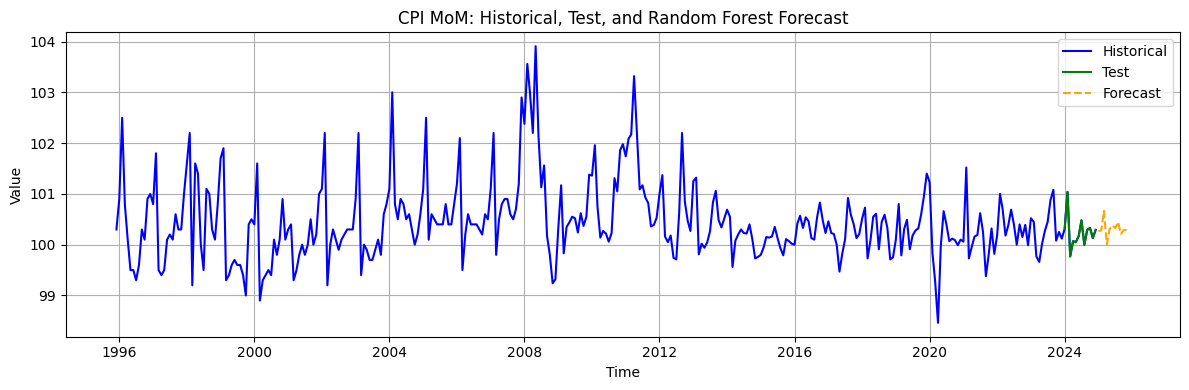

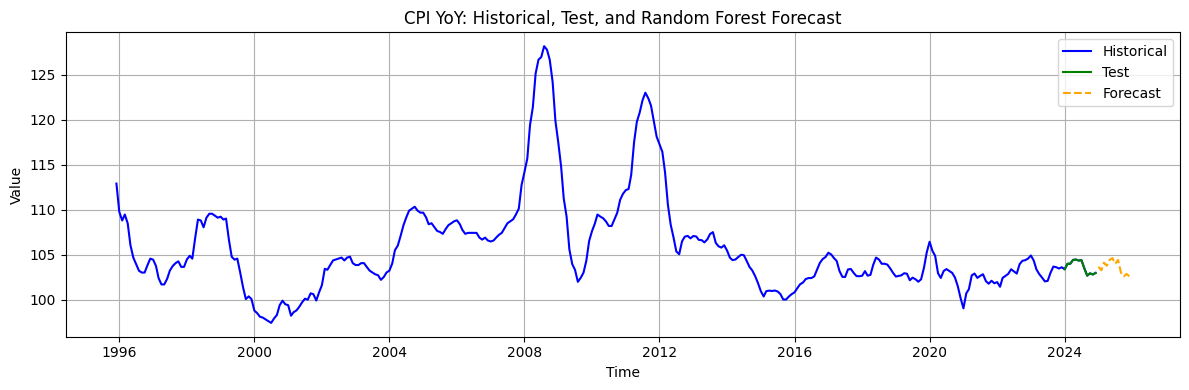

<Figure size 500x300 with 0 Axes>

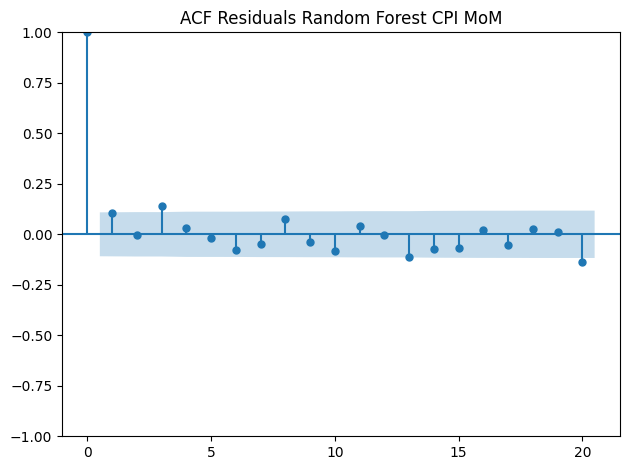

<Figure size 500x300 with 0 Axes>

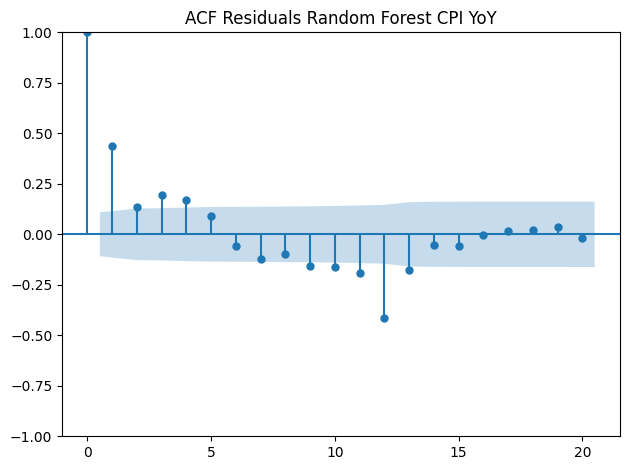

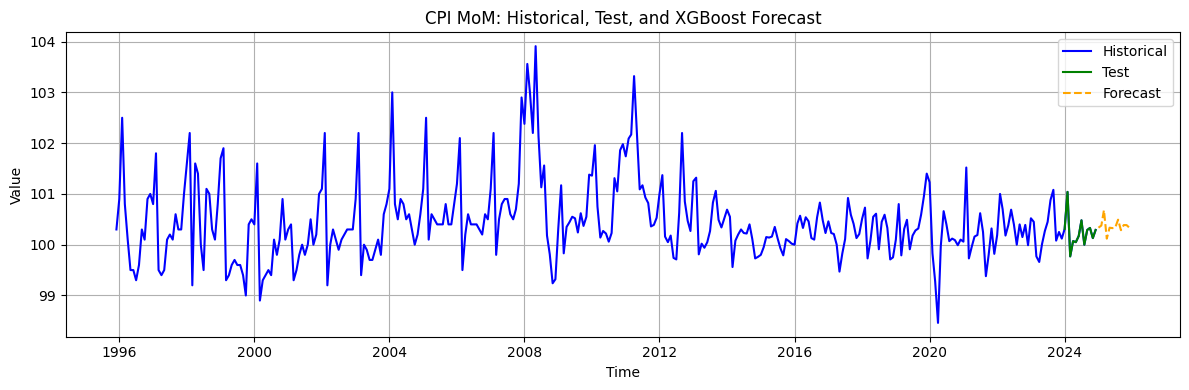

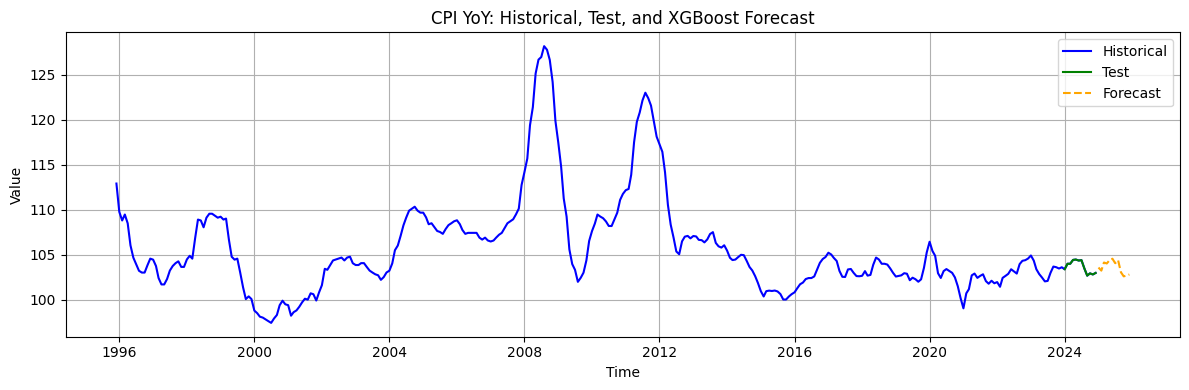

<Figure size 500x300 with 0 Axes>

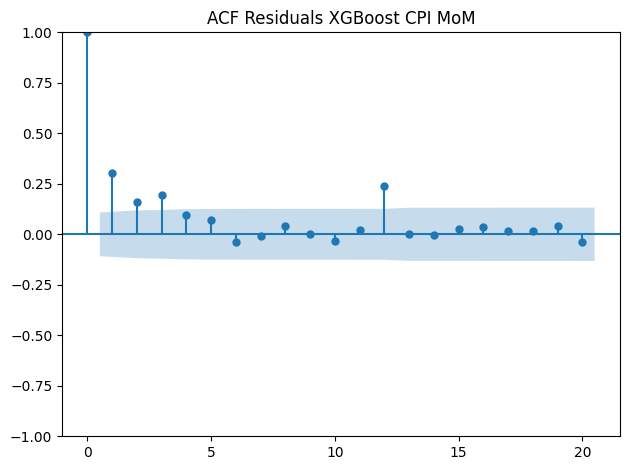

<Figure size 500x300 with 0 Axes>

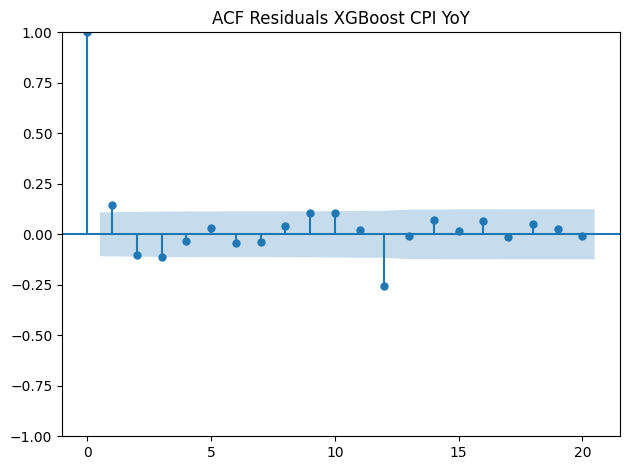

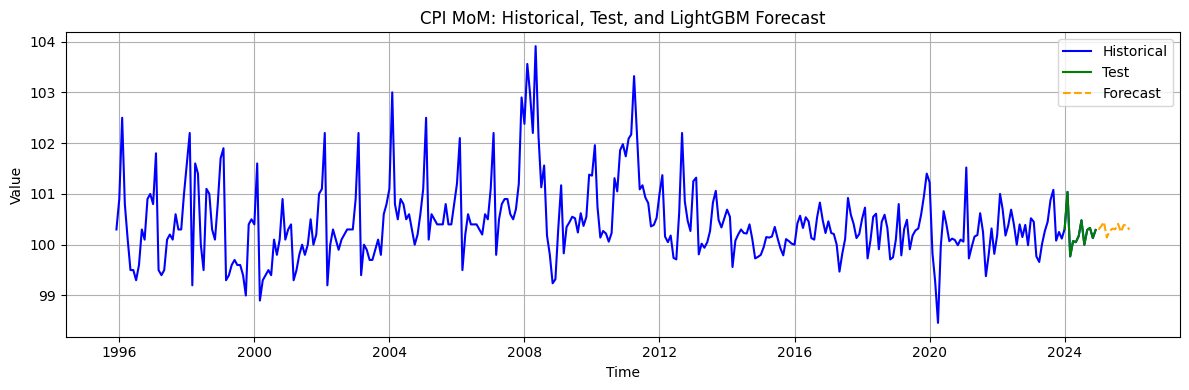

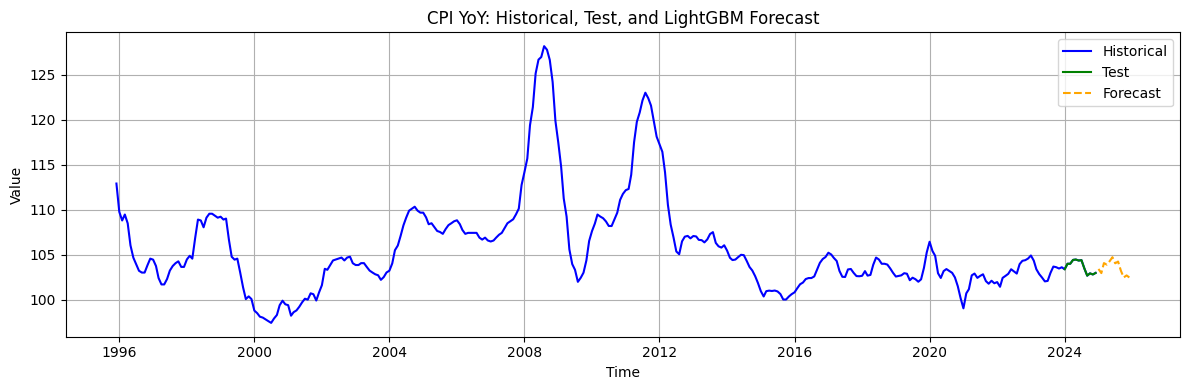

<Figure size 500x300 with 0 Axes>

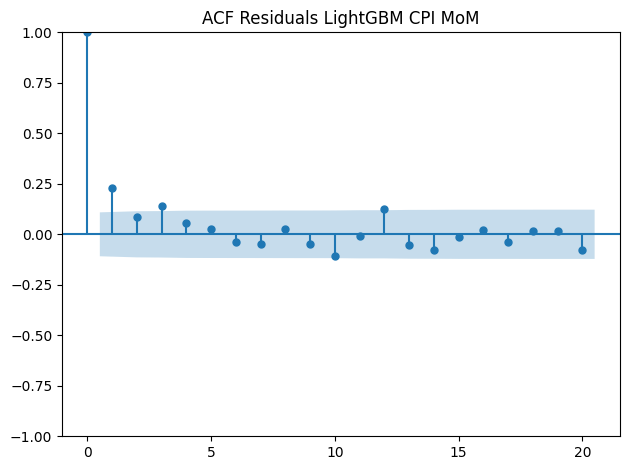

<Figure size 500x300 with 0 Axes>

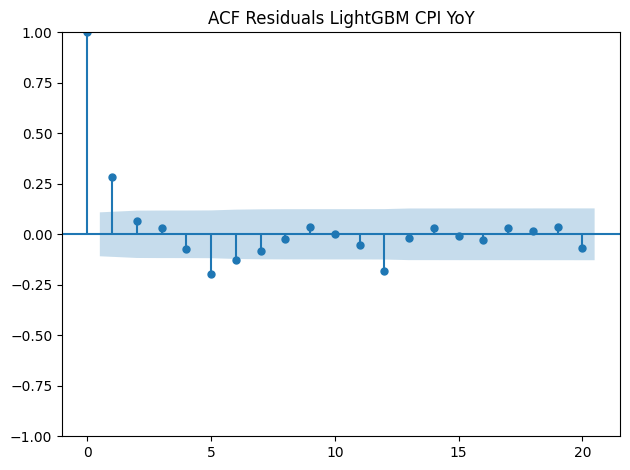

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os
warnings.filterwarnings("ignore")

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(((predicted - actual) ** 2).mean())
    mae = np.mean(np.abs(predicted - actual))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    return rmse, mae, mape

# Hàm trực quan hóa dự báo
def plot_forecast(historical, test, forecast, forecast_index, title, ylabel, filename, confidence_intervals=None):
    plt.figure(figsize=(12, 4))
    plt.plot(historical.index, historical, label='Historical', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='orange', linestyle='--')
    if confidence_intervals is not None:
        plt.fill_between(forecast_index, confidence_intervals[0], confidence_intervals[1], 
                         color='orange', alpha=0.2, label='Confidence Interval')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm trực quan hóa ACF phần dư
def plot_residual_acf(residuals, title, filename):
    plt.figure(figsize=(5, 3))
    plot_acf(residuals, lags=20, title=title)
    plt.tight_layout()
    plt.savefig(f'img/{filename}')
    # plt.close()

# Hàm tạo đặc trưng cho mô hình học máy
def create_ml_features(df, target_col, exog_cols, lags=[1, 2, 3]):
    data = df.copy()
    for lag in lags:
        data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    features = data[[f'{target_col}_lag_{lag}' for lag in lags] + exog_cols].dropna()
    target = data[target_col].loc[features.index]
    return features, target

# Hàm chạy Random Forest
def run_random_forest(train, test, exog_train, exog_test, forecast_index, param_grid=None):
    if param_grid:
        print("Tối ưu tham số cho Random Forest...")
        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(exog_train, train)
        model = grid_search.best_estimator_
        print(f"Tham số tốt nhất Random Forest: {grid_search.best_params_}")
    else:
        model = RandomForestRegressor(random_state=42)
        model.fit(exog_train, train)
    
    forecast = model.predict(exog_test)
    residuals = train - model.predict(exog_train)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return pd.Series(forecast, index=forecast_index), residuals, rmse, mae, mape

# Hàm chạy XGBoost
def run_xgboost(train, test, exog_train, exog_test, forecast_index, param_grid=None):
    if param_grid:
        print("Tối ưu tham số cho XGBoost...")
        xgb = XGBRegressor(random_state=42)
        grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(exog_train, train)
        model = grid_search.best_estimator_
        print(f"Tham số tốt nhất XGBoost: {grid_search.best_params_}")
    else:
        model = XGBRegressor(random_state=42)
        model.fit(exog_train, train)
    
    forecast = model.predict(exog_test)
    residuals = train - model.predict(exog_train)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return pd.Series(forecast, index=forecast_index), residuals, rmse, mae, mape

# Hàm chạy LightGBM
def run_lightgbm(train, test, exog_train, exog_test, forecast_index, param_grid=None):
    if param_grid:
        print("Tối ưu tham số cho LightGBM...")
        lgbm = LGBMRegressor(random_state=42)
        grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(exog_train, train)
        model = grid_search.best_estimator_
        print(f"Tham số tốt nhất LightGBM: {grid_search.best_params_}")
    else:
        model = LGBMRegressor(random_state=42)
        model.fit(exog_train, train)
    
    forecast = model.predict(exog_test)
    residuals = train - model.predict(exog_train)
    rmse, mae, mape = calculate_metrics(test, forecast)
    return pd.Series(forecast, index=forecast_index), residuals, rmse, mae, mape

# Main execution
if __name__ == "__main__":
    # Tạo thư mục img
    if not os.path.exists('img'):
        os.makedirs('img')
    
    # Đọc dữ liệu
    file_path = "data/analyzed_time_series.csv"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại!")
    
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
    
    if df['time'].isna().any():
        print("Cảnh báo: Có giá trị thời gian không hợp lệ!")
        df = df.dropna(subset=['time'])
    
    df = df.sort_values(by='time')
    df.set_index('time', inplace=True)
    
    # Kiểm tra cột cần thiết
    required_columns = ['cpi_mom', 'cpi_yoy', 'oil_price', 'gold_price', 'interest_rate']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Thiếu một hoặc nhiều cột cần thiết trong dữ liệu!")
    
    # Kiểm tra độ dài dữ liệu
    if len(df) < 24:
        raise ValueError("Dữ liệu quá ngắn, cần ít nhất 24 tháng!")
    
    # Chia tập train/test
    train_mom, test_mom = df['cpi_mom'][:-12], df['cpi_mom'][-12:]
    train_yoy, test_yoy = df['cpi_yoy'][:-12], df['cpi_yoy'][-12:]
    
    # Tạo đặc trưng cho mô hình học máy
    lags = [1, 2, 3, 6, 12]
    mom_features, mom_target = create_ml_features(df, 'cpi_mom', ['oil_price', 'gold_price'], lags)
    yoy_features, yoy_target = create_ml_features(df, 'cpi_yoy', ['oil_price', 'gold_price'], lags)
    
    # Chia đặc trưng train/test
    train_features_mom, test_features_mom = mom_features[:-12], mom_features[-12:]
    train_target_mom, test_target_mom = mom_target[:-12], mom_target[-12:]
    train_features_yoy, test_features_yoy = yoy_features[:-12], yoy_features[-12:]
    train_target_yoy, test_target_yoy = yoy_target[:-12], yoy_target[-12:]
    
    # Kiểm tra đặc trưng
    print("Đặc trưng train_mom:\n", train_features_mom.head())
    print("Đặc trưng test_mom:\n", test_features_mom.head())
    print("Đặc trưng train_yoy:\n", train_features_yoy.head())
    print("Đặc trưng test_yoy:\n", test_features_yoy.head())
    
    # Tạo chỉ mục dự báo
    last_date = df.index[-1].to_period('M').to_timestamp()
    forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
    
    # Định nghĩa lưới tham số cho mô hình học máy
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    }
    
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }
    
    lgbm_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }
    
    # Danh sách mô hình và tham số
    models = [
        ('Random Forest', run_random_forest, {'mom': {'param_grid': rf_param_grid}, 
                                             'yoy': {'param_grid': rf_param_grid}}),
        ('XGBoost', run_xgboost, {'mom': {'param_grid': xgb_param_grid}, 
                                  'yoy': {'param_grid': xgb_param_grid}}),
        ('LightGBM', run_lightgbm, {'mom': {'param_grid': lgbm_param_grid}, 
                                    'yoy': {'param_grid': lgbm_param_grid}})
    ]
    
    # Chạy từng mô hình và lưu kết quả
    results = {'mom': {}, 'yoy': {}}
    for model_name, model_func, params in models:
        # CPI MoM
        args = [train_target_mom, test_target_mom, train_features_mom, test_features_mom, test_mom.index]
        print(f"Chạy mô hình {model_name} cho CPI MoM với args: {args}")
        forecast, residuals, rmse, mae, mape = model_func(*args, param_grid=params['mom']['param_grid'])
        results['mom'][model_name] = {'forecast': forecast, 'residuals': residuals, 
                                     'rmse': rmse, 'mae': mae, 'mape': mape}
        
        # CPI YoY
        args = [train_target_yoy, test_target_yoy, train_features_yoy, test_features_yoy, test_yoy.index]
        print(f"Chạy mô hình {model_name} cho CPI YoY với args: {args}")
        forecast, residuals, rmse, mae, mape = model_func(*args, param_grid=params['yoy']['param_grid'])
        results['yoy'][model_name] = {'forecast': forecast, 'residuals': residuals, 
                                     'rmse': rmse, 'mae': mae, 'mape': mape}
        
        # Trực quan hóa
        plot_forecast(df['cpi_mom'], test_mom, results['mom'][model_name]['forecast'], forecast_index,
                      f'CPI MoM: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_mom_{model_name.lower().replace(" ", "_")}_forecast.png')
        plot_forecast(df['cpi_yoy'], test_yoy, results['yoy'][model_name]['forecast'], forecast_index,
                      f'CPI YoY: Historical, Test, and {model_name} Forecast', 'Value',
                      f'cpi_yoy_{model_name.lower().replace(" ", "_")}_forecast.png')
        
        # ACF phần dư
        plot_residual_acf(results['mom'][model_name]['residuals'], f'ACF Residuals {model_name} CPI MoM',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_mom.png')
        plot_residual_acf(results['yoy'][model_name]['residuals'], f'ACF Residuals {model_name} CPI YoY',
                          f'residual_acf_{model_name.lower().replace(" ", "_")}_yoy.png')
    
    # In kết quả
    for metric in ['rmse', 'mae', 'mape']:
        print(f"\n{metric.upper()} Results:")
        for model_name in results['mom']:
            print(f"{model_name} CPI MoM: {results['mom'][model_name][metric]:.4f}")
            print(f"{model_name} CPI YoY: {results['yoy'][model_name][metric]:.4f}")